# Introduction to Spiking Neural Networks

In this notebook, we will explore Spiking Neural Networks (SNNs) and see how they stack up against the Convolutional Neural Networks (CNNs) we started learning about earlier in this course: are SNNs a more energy efficient alternative to CNNs? 

Spiked Neural Networks (SNN) are artificial neural networks that mimic the architecture of neurons. Similarly to how neurons emit a signal after an action potential  is exceeded, SNN layers are discrete values that are spiking or non-spiking at any given time. Given their unique architecture, SSNs require neuromorphic computers in which chips are specifically designed to accommodate these processes.

Since SNN are dynamic and change based on time, they are great at processing dynamic inputs such as videos. Additionally, their use of matrix addition as opposed matrix multiplication reduces energy consumption greatly during inference. However, the biggest challenge when working with these networks is in the training, as gradients are essentially nonexistent when each layer is either a 1 or 0. 

![SNN](snn.jpeg) Photo from: towardsdatascience.com

To tackle this challenge, as shown by Wu et al.’s A Little Energy Goes a Long Way: Build an Energy-Efficient, Accurate Spiking Neural Network From Convolutional Neural Network, one can instead convert an already trained CNN into an SNN to allow for both comparable accuracy and reduced energy consumption.

Before diving into our comparisons between CNNs and SNNs, we should first establish why it is important for us to utilize neural networks that are energy efficient. Our motivation for this project is heavily inspired by the paper, On the Dangers of Stochastic Parrots: Can Language Models Be Too Big?. In this paper, Bender et al. highlight the possible negative implications of large language models, but the concerns are applicable to training neural networks in general. Bender et al. encourage researchers to weigh the costs and benefits of training their models before doing so, and shift to a mindset of careful planning, which includes experimenting with more energy efficient alternatives, such as SNNs. 

It is no mystery that training neural networks is a costly endeavor that has a lasting negative environmental impact, specifically through CO2 emissions. The environmental burden caused by training these models disproportionately impacts marginalized communities, who do not have the resources to combat the harms. By utilizing more energy efficient alternatives, such as SNNs, researchers/companies can scale up their experiments ethically, ensuring that they remain mindful of the environment and underrepresented communities when creating their models. If saving the environment and marginalized communities is not convincing enough for researchers, utilizing energy efficient models also has an economic benefit that would in turn lower the barrier to entry for experimenting with neural networks, thus increasing the diversity of people who can contribute to neural network research.

![rainforest](rainforest.jpeg) Photo from: planetnatural.com

Our exploration of SNNs represents only a small portion of the research that has been done to lessen deep learning’s carbon footprint. There is still so much left to be done to ensure that this growing field of research prioritizes diversity and environmental wellness.


Let's first make sure to import all the necessary libraries we will use in our code. You may need to install some of these packages onto your device first such as sinabs.

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import numpy as np

import matplotlib.pyplot as plt

import sinabs.layers as sl
from sinabs.from_torch import from_model


----
### Test 1 : MNIST
----

For our first test we will create a cnn and snn that can classify MNIST data. First let's create a class to provide data for the CNN, the __getitem__ method of this class will simply provide a 1×28×28 representation of an MNIST image along with its label.

In [181]:
class CNN_MNIST(datasets.MNIST):
        def __init__(self, root, train=True):
            super().__init__(
                root=root, train=train, download=True, transform=transforms.ToTensor()
            )

        def __getitem__(self, index):
            img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
            return img, target
        
mnist_train = CNN_MNIST("./data", train=True)
mnist_train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
mnist_test = CNN_MNIST("./data", train=False)
mnist_test_loader = DataLoader(mnist_test, batch_size=10, shuffle=False)

We can next create a simple cnn using a torch sequential container and train it using the MNIST data loader we just created. For MNIST data 2 epochs should be sufficient, but you can increase this number to aim for higher accuracy.

In [182]:
def create_mnist_cnn():
    cnn = nn.Sequential(
        nn.Conv2d(1, 20, 5, 1, bias=False),
        nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(20, 32, 5, 1, bias=False),
        nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(32, 128, 3, 1, bias=False),
        nn.ReLU(),

        nn.AvgPool2d(2, 2),
        nn.Flatten(),

        nn.Linear(128, 500, bias=False),
        nn.ReLU(),
        nn.Linear(500, 10, bias=False),
    )
    return cnn

def train_cnn(cnn, train_loader, epochs):
    cnn.train()
    optim = torch.optim.Adam(cnn.parameters(), lr=1e-3)

    for n in tqdm(range(epochs)):
        for data, target in iter(train_loader):
            output = cnn(data)
            optim.zero_grad()

            loss = F.cross_entropy(output, target)
            loss.backward()
            optim.step()
    return cnn

mnist_cnn = create_mnist_cnn()
mnist_cnn = train_cnn(mnist_cnn, train_loader=mnist_train_loader, epochs = 2)

  0%|          | 0/2 [00:00<?, ?it/s]

We next want to write a function to evaluate the accuracy of our CNN.

In [219]:
def cnn_accuracy(cnn, test_loader, will_print = True):
    correct_predictions = []

    for data, target in tqdm(test_loader):
        output = cnn(data)

        prediction = output.argmax(dim=1, keepdim=True)

        correct_predictions.append(prediction.eq(target.view_as(prediction)))

    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    if (will_print):
        print(
            f"Classification accuracy: {proportion_correct*100}%"
        )
    return proportion_correct

cnn_accuracy(mnist_cnn, test_loader=mnist_test_loader)


  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 97.57000000000001%


0.9757

Great! The accuracy of our simple CNN should be quite high, around ~97%, let's convert this CNN to an SNN now.
The first step is to change our MNIST data class slightly so that  the tensor we pass in only consists of 0s or 1s. These are the presynaptic spikes that will modulate the neurons in the SNN. We also need to generate input data for each timestep. We will do this by adding a dimension to the input tensor the length of our timestep (which we will have set to 100 as a default value). For each input, a tensor the size of the original input consisting of a random float will be generated and then compared to the MNIST float value. Thus, for each timestep a pixel of n% value will have an n% chance of being a 1 in the tensor and 0 otherwise.

In [184]:
class SNN_MNIST(datasets.MNIST):
        def __init__(self, root, train=True, time_window = 100):
            super().__init__(
                root=root, train=train, download=True, transform=transforms.ToTensor()
            )
            self.time_window = time_window

        def __getitem__(self, index):
            img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
            img = (torch.rand(self.time_window, *img.shape) < img).float()
            return img, target

mnist_test_batch_size = 500
spike_mnist_test = SNN_MNIST("./data", train=False)
spike_test_loader = DataLoader(spike_mnist_test, batch_size=mnist_test_batch_size, shuffle=False)

Before we go further let's visualize what this dataloader will give us.
Here is an MNIST image usually looks like:

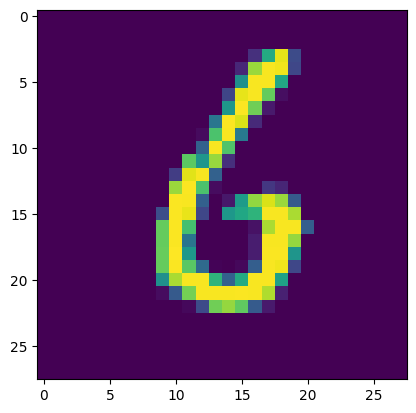

In [185]:
mnist_id = 50
img, label = mnist_test[mnist_id]
img = torch.squeeze(img)  
plt.imshow(img)
plt.show()

And here is what an MNIST image from the SNN dataloader looks like: Feel free to rerun the code a couple times to get a sense of the random generation going on.

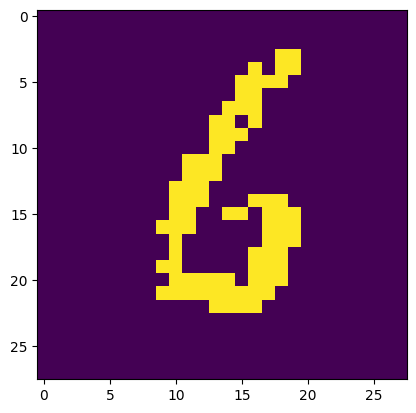

In [186]:
img, label = spike_mnist_test[mnist_id]
img = img[1,]
img = torch.squeeze(img)  
plt.imshow(img)
plt.show()

Okay, time to create our SNN now! This step is very simple using Sinabs. We just need to use their from_model() function and remember the size of a single input (1,28,28) and the timestep we want to use (100).

In [187]:
def convert_to_snn(cnn, input_shape, timesteps):
    snn = from_model(
        cnn, input_shape=input_shape, add_spiking_output=True, synops=False, num_timesteps=timesteps
    )
    return snn

input_shape = (1, 28, 28)
timesteps = 100
mnist_snn = convert_to_snn(mnist_cnn, input_shape=input_shape, timesteps=timesteps)

Now we can write a function to evaluate the accuracy of our SNN and compare!

In [220]:
def snn_accuracy(snn, test_loader, test_batch_size, will_print = True):
    correct_predictions = []

    for data, target in tqdm(test_loader):
        data = sl.FlattenTime()(data)
        with torch.no_grad():
            output = snn(data)
            output = output.unflatten(
                0, (test_batch_size, output.shape[0] // test_batch_size)
            )

        pred = output.sum(1).argmax(dim=1, keepdim=True)
        correct_predictions.append(pred.eq(target.view_as(pred)))
    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    if (will_print):
        print(
            f"Classification accuracy: {proportion_correct*100}%"
        )
    return proportion_correct
print("CNN accuracy: ")
cnn_accuracy(mnist_cnn, test_loader=mnist_test_loader)
print("SNN accuracy: ")
snn_accuracy(mnist_snn, test_loader = spike_test_loader, test_batch_size=mnist_test_batch_size)

CNN accuracy: 


  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 97.57000000000001%
SNN accuracy: 


  0%|          | 0/20 [00:00<?, ?it/s]

Classification accuracy: 83.89%


0.8389

We can also now visualize the post-synaptic spikes to see how our SNN is classifying MNIST images. Change around the mnist_id number to look at other data. This visualization is also useful because we can see what other numbers the model sometimes confuses the correct answer with.

Label: 6


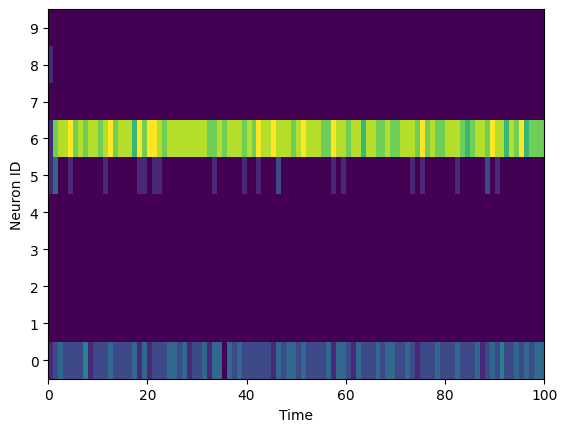

In [189]:
#Change this number to visualize other data
mnist_id = 50

img, label = spike_mnist_test[mnist_id]
snn_output = mnist_snn(img)

print("Label: " + str(label.item()))
plt.pcolormesh(snn_output.T.detach().cpu())
plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time")
plt.show()

----
### Test 2: CIFAR-10
----

One of the great aspects about this conversion pipeline is we can create an SNN for other types of data with minimal changes. Let's next create an SNN for classifying CIFAR-10 images which are 3 (RGB) channel. Let's first make a CIFAR-10 class for CNN training.

In [190]:
class CNN_CIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True):
            super().__init__(
                root=root, train=train, download=True, transform=transforms.ToTensor()
            )

        def __getitem__(self, index):
            img, target = self.data[index]/255, self.targets[index]
            img = torch.from_numpy(img)
            img = img.float()
            img = torch.transpose(img, 0, 2)
            return img, target

cifar_train = CNN_CIFAR10("./data", train=True)
cifar_train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True)
cifar_test = CNN_CIFAR10("./data", train=False)
cifar_test_loader = DataLoader(cifar_test, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Now we will create and train a CNN that takes 3 channel data. We will keep the epochs low for the sake of time, but feel free to increase the number to try for higher accuracy!

In [191]:
def create_cifar_cnn(): 
    cnn = nn.Sequential(
        nn.Conv2d(3, 20, 5, 1, bias=False),
        nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(20, 32, 5, 1, bias=False),
        nn.ReLU(),
        nn.AvgPool2d(2, 2),
        nn.Conv2d(32, 128, 3, 1, bias=False),
        nn.ReLU(),

        nn.AvgPool2d(2, 2),
        nn.Flatten(),

        nn.Linear(128, 500, bias=False),
        nn.ReLU(),
        nn.Linear(500, 10, bias=False),     
    )
    return cnn

cifar_cnn = create_cifar_cnn()
cifar_cnn = train_cnn(cifar_cnn, train_loader=cifar_train_loader, epochs = 5)
cnn_accuracy(cifar_cnn, test_loader=cifar_test_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 53.949999999999996%


Let's next make our CIFAR data class for the SNN. Again, we need to return a tensor with an extra dimension the length of the number of timesteps and only filled with 0 or 1s. 

In [199]:
class SNN_CIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True, time_window = 100):
            super().__init__(
                root=root, train=train, download=True, transform=transforms.ToTensor()
            )
            self.time_window = time_window

        def __getitem__(self, index):
            img, target = self.data[index]/255, self.targets[index]
            img = torch.from_numpy(img)
            img = img.float()
            img = torch.transpose(img, 0, 2)
            img = (torch.rand(self.time_window, *img.shape) < img).float()
            return img, target

time_window = 100
cifar_test_batch_size = 10
cifar_spike_test = SNN_CIFAR10(
        "./data", train=False, time_window = time_window
    )
cifar_spike_test_loader = DataLoader(
    cifar_spike_test, batch_size=cifar_test_batch_size, shuffle=False
)

Files already downloaded and verified


We can visualize this process like we did for the MNIST data. First print the actual image:

Label: 9
Name: truck


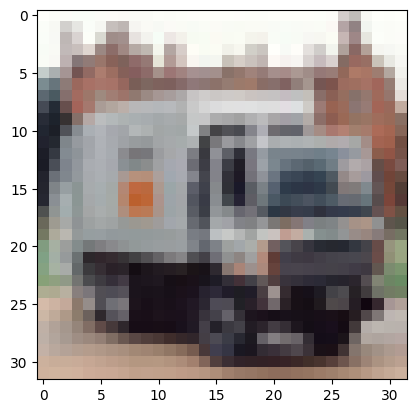

In [200]:
cifar_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
cifar_image_id = 11
img, label = cifar_test[cifar_image_id]
img = torch.transpose(img, 0, 2)
print("Label: " + str(label))
print("Name: " + cifar_names[label])
plt.imshow(img)
plt.show()

Now print the a slice of the result from the snn data loader. Compared to the MNIST data, instead of 1 channel we now have 3. Therefore 8 possible colors will be present in the resulting image. Rerun the code a couple of times to help visualize the randomization process.

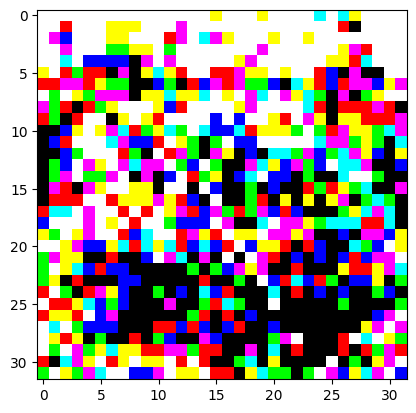

In [201]:
img, label = cifar_spike_test[cifar_image_id]
img = img[2,:]
img = torch.squeeze(img)
img = torch.transpose(img, 0, 2)
plt.imshow(img)
plt.show()

Now we can use the same cnn to snn conversion function, and compare accuracies.

In [202]:
input_shape = (3, 32, 32)
timesteps = 100
cifar_snn = convert_to_snn(cifar_cnn, input_shape=input_shape, timesteps=timesteps)

print("CNN accuracy: ")
cnn_accuracy(cifar_cnn, test_loader=cifar_test_loader)
print("SNN accuracy: ")
snn_accuracy(cifar_snn, test_loader = cifar_spike_test_loader, test_batch_size=cifar_test_batch_size)


CNN accuracy: 


  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 53.949999999999996%
SNN accuracy: 


  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 51.7%


Now we can again visualize the post-synaptic spikes to see how our SNN is classifying the CIFAR-10 images. Change around the cifar_image_id number to look at other data. This visualization is also useful because we can see what other images the model sometimes confuses the correct answer with. As a reminder here is the order of CIFAR-10 classes: 0. airplane 1. automobile 2. bird 3. cat 4. deer 5. dog 6. frog 7. horse 8. ship 9. truck

Label: 9
Name: truck


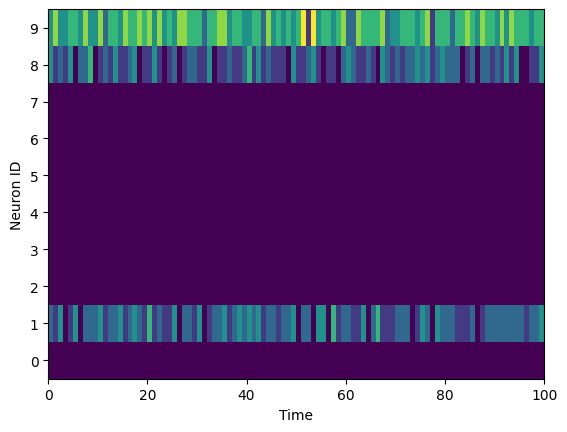

In [212]:
#Change this number to visualize other data
cifar_image_id = 11

img, label = cifar_spike_test[cifar_image_id]
snn_output = cifar_snn(img)

print("Label: " + str(label))
print("Name: " + cifar_names[label])
plt.pcolormesh(snn_output.T.detach().cpu())
plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time")
plt.show()

----
### Test 3: Time and Energy Usage
----

Since our primary motivation for creating spiking nerual networks was to find  a more energy efficient model, we ideally would compare the energy usage of our CNN and SNN on these classification tests. However, methods to classify energy usage that can run on all computers are quite diffifult to come by. Instead we will measure the inference time of tasks. First, however, let us see how quick we can make our SNN without compromising accuracy. Returning to our SNN for MNIST, we will test a range of timestep amounts to observe at what threshold our accuracy starts deteriorating. 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

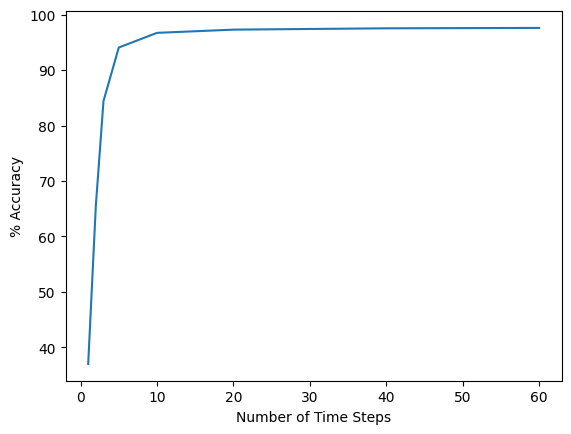

In [236]:
mnist_test_batch_size = 500
input_shape = (1, 28, 28)

timesteps = [1, 2, 3, 5, 10, 20, 40, 60]
accuracies = []
for timestep in timesteps:
    spike_mnist_test = SNN_MNIST("./data", train=False, time_window=timestep)
    spike_test_loader = DataLoader(spike_mnist_test, batch_size=mnist_test_batch_size, shuffle=False)
    mnist_snn = convert_to_snn(mnist_cnn, input_shape=input_shape, timesteps=timestep)
    accuracy = snn_accuracy(mnist_snn, test_loader = spike_test_loader, test_batch_size=mnist_test_batch_size, will_print=False)
    accuracies.append(accuracy*100)
plt.plot(timesteps, accuracies)
plt.xlabel("Number of Time Steps")
plt.ylabel("% Accuracy")
plt.show()    

So it appears we can reduce the number of timesteps to as low as ~5 while still keeping accuracy over 90%. Let's next measure the inference time while changing the number of timesteps using a slightly altered accuracy function.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

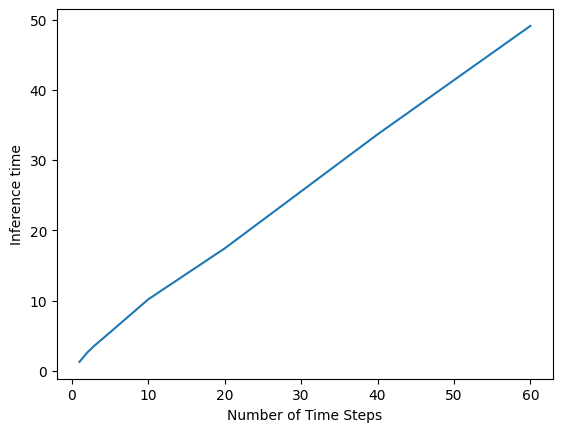

In [237]:
import time

def snn_inference_time(snn, test_loader, test_batch_size):
    correct_predictions = []
    start_time = time.time()
    for data, target in tqdm(test_loader):
        data = sl.FlattenTime()(data)
        with torch.no_grad():
            output = snn(data)
            output = output.unflatten(
                0, (test_batch_size, output.shape[0] // test_batch_size)
            )

        pred = output.sum(1).argmax(dim=1, keepdim=True)
        correct_predictions.append(pred.eq(target.view_as(pred)))
    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time


inference_times = []
for timestep in timesteps:
    spike_mnist_test = SNN_MNIST("./data", train=False, time_window=timestep)
    spike_test_loader = DataLoader(spike_mnist_test, batch_size=mnist_test_batch_size, shuffle=False)
    mnist_snn = convert_to_snn(mnist_cnn, input_shape=input_shape, timesteps=timestep)
    inference_time = snn_inference_time(mnist_snn, test_loader = spike_test_loader, test_batch_size=mnist_test_batch_size)
    inference_times.append(inference_time)
plt.plot(timesteps, inference_times)
plt.xlabel("Number of Time Steps")
plt.ylabel("Inference time")
plt.show()    

As we might expect, the relationship between the number of timesteps and the inference time is essentially linear. Let's plot the inference of the CNN as well.

  0%|          | 0/20 [00:00<?, ?it/s]

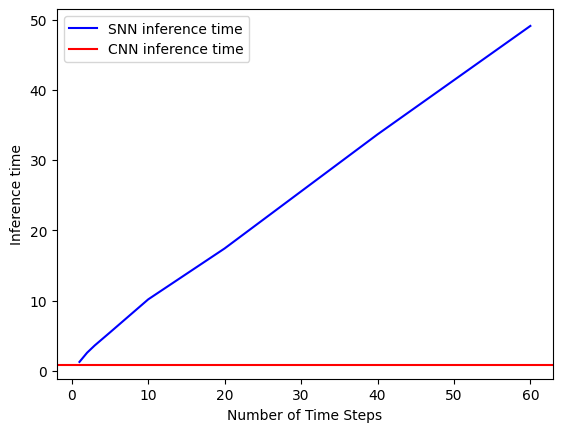

In [242]:
def cnn_inference_time(cnn, test_loader):
    correct_predictions = []
    start_time = time.time()
    for data, target in tqdm(test_loader):
        output = cnn(data)

        prediction = output.argmax(dim=1, keepdim=True)

        correct_predictions.append(prediction.eq(target.view_as(prediction)))

    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time
mnist_test_loader = DataLoader(mnist_test, batch_size=mnist_test_batch_size, shuffle=False)
cnn_it = cnn_inference_time(mnist_cnn, test_loader=mnist_test_loader)
plt.plot(timesteps, inference_times, color="blue", label = "SNN inference time")
plt.xlabel("Number of Time Steps")
plt.ylabel("Inference time")
plt.axhline(cnn_it,color = "red", label="CNN inference time")
plt.legend()
plt.show()   

Even on the smallest number of timesteps (1), the CNN inference time is less than that for the SNN. This is because to take advantage of spiking neural network efficiencies, one would need a neuromorphic computer with a chip that employs physical artificial neurons for computations. Perhaps in the future we will all have neuromorphic computers and the results from the python notebook will look quite different!

Finally, if you happen to be on a Linux computer you can pseudo-directly measure the energy use of a function by using a package such as pyRAPL. Try out the code below if you're interested!

In [246]:
import pyRAPL
pyRAPL.setup()

@pyRAPL.measure
def snn_energy_usage(snn, test_loader, test_batch_size):
    correct_predictions = []
    start_time = time.time()
    for data, target in tqdm(test_loader):
        data = sl.FlattenTime()(data)
        with torch.no_grad():
            output = snn(data)
            output = output.unflatten(
                0, (test_batch_size, output.shape[0] // test_batch_size)
            )

        pred = output.sum(1).argmax(dim=1, keepdim=True)
        correct_predictions.append(pred.eq(target.view_as(pred)))
    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

@pyRAPL.measure
def cnn_energy_usage(cnn, test_loader):
    correct_predictions = []
    start_time = time.time()
    for data, target in tqdm(test_loader):
        output = cnn(data)

        prediction = output.argmax(dim=1, keepdim=True)

        correct_predictions.append(prediction.eq(target.view_as(prediction)))

    correct_predictions = torch.cat(correct_predictions)
    proportion_correct = correct_predictions.sum().item()/(len(correct_predictions))
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

mnist_test_batch_size = 500
input_shape = (1, 28, 28)

timesteps = [1, 2, 3]
print("SNN energy usage: ")
for timestep in timesteps:
    print("Number of timesteps: " + str(timestep))
    spike_mnist_test = SNN_MNIST("./data", train=False, time_window=timestep)
    spike_test_loader = DataLoader(spike_mnist_test, batch_size=mnist_test_batch_size, shuffle=False)
    mnist_snn = convert_to_snn(mnist_cnn, input_shape=input_shape, timesteps=timestep)
    snn_energy_usage(mnist_snn, test_loader = spike_test_loader, test_batch_size=mnist_test_batch_size)
    
print("CNN energy usage: ")
mnist_test_loader = DataLoader(mnist_test, batch_size=mnist_test_batch_size, shuffle=False)
cnn_it = cnn_energy_usage(mnist_cnn, test_loader=mnist_test_loader)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyRAPL/device_api.py:33: SyntaxWarning: invalid escape sequence '\d'
  cpu_id_tmp = re.findall('\d+|-', api_file.readline().strip())


FileNotFoundError: [Errno 2] No such file or directory: '/sys/devices/system/cpu/present'